In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

In [2]:
import json
from tqdm import tqdm
import time

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
def conv1x1(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)

def conv3x3(in_channels, out_channels, stride=1, padding=1, dilation=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=padding, bias=False, dilation=dilation)

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, batchnorm=True, residual=True):
        super().__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        if batchnorm:        
            self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        if batchnorm:
            self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.batchnorm = batchnorm
        self.residual = residual
    
    def forward(self, x):
        out = self.conv1(x)
        if self.batchnorm:
            out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        if self.batchnorm:
            out = self.bn2(out)
        
        if self.residual:
            if self.downsample is not None:
                out += self.downsample(x)
            else:
                out += x
        
        out = self.relu(out)

        return out

def make_layer(block, in_channels, out_channels, n_blocks=2, stride=1, batchnorm=True, residual=True):
    if stride != 1:
        downsample = nn.Sequential(conv1x1(in_channels, out_channels, stride))
    else:
        downsample = None
    
    layers = []
    layers.append(block(in_channels, out_channels, stride, downsample, batchnorm, residual))
    for _ in range(1, n_blocks):
        layers.append(block(out_channels, out_channels, batchnorm=batchnorm, residual=residual))
    return nn.Sequential(*layers)

In [5]:
class Resnet(nn.Module):
    def __init__(self, n_classes=10, batchnorm=True, residual=True):
        super().__init__()
        self.n_classes = n_classes
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        if batchnorm:
            self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = make_layer(BasicBlock, 64, 64, n_blocks=3, batchnorm=batchnorm, residual=residual)
        self.layer2 = make_layer(BasicBlock, 64, 128, n_blocks=4, stride=2, batchnorm=batchnorm, residual=residual)
        self.layer3 = make_layer(BasicBlock, 128, 256, n_blocks=6, stride=2, batchnorm=batchnorm, residual=residual)
        self.layer4 = make_layer(BasicBlock, 256, 512, n_blocks=3, stride=2, batchnorm=batchnorm, residual=residual)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, n_classes)
        self.batchnorm = batchnorm
        self.residual = residual
        
    def forward(self, x):
        x = self.conv1(x)
        if self.batchnorm:
            x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [6]:
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

_test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=False, 
                                            transform=transform, download=True)

n_train = int(len(train_dataset)*0.9)
n_valid = len(train_dataset) - n_train
print(len(train_dataset), n_train, n_valid)
_train_dataset, _valid_dataset = torch.utils.data.random_split(train_dataset, [n_train, n_valid])


Files already downloaded and verified
Files already downloaded and verified
50000 45000 5000


In [7]:
def train_epoch(model, optimizer, criterion, train_loader, validation_loader, epoch, device=device):
    t_start = time.time()
    
    model.train()
    train_loss = 0.0
    train_acc = 0
    
    for train_x, train_y in train_loader:
        train_x = train_x.to(device)
        train_y = train_y.to(device)
        
        # Forward pass
        outputs = model(train_x)
        loss = criterion(outputs, train_y)
        train_loss += loss.data.item() * train_x.size(0)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        train_acc += (predicted == train_y).sum().item()
    
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_acc / len(train_loader.dataset)
    
    model.eval()
    valid_loss = 0.0
    valid_acc = 0
    for valid_x, valid_y in validation_loader:
        valid_x = valid_x.to(device)
        valid_y = valid_y.to(device)

        outputs = model(valid_x)
        loss = criterion(outputs, valid_y)
        valid_loss += loss.data.item() * valid_x.size(0)
        
        _, predicted = torch.max(outputs.data, 1)
        valid_acc += (predicted == valid_y).sum().item()
        
    valid_loss = valid_loss / len(validation_loader.dataset)
    valid_acc = valid_acc / len(validation_loader.dataset)

    return time.time() - t_start, train_loss, train_acc, valid_loss, valid_acc


def _update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def train(model, optimizer, criterion, train_loader, validation_loader, epochs=20, device=device, update_lr=True):
    lst_train_loss = []
    lst_train_acc = []
    lst_valid_loss = []
    lst_valid_acc = []
    curr_lr = optimizer.param_groups[0]['lr']

    for epoch in range(epochs):
        t_epoch, train_loss, train_acc, valid_loss, valid_acc = train_epoch(model, optimizer, criterion, train_loader, validation_loader, epoch, device)
        lst_train_loss.append(train_loss)
        lst_train_acc.append(train_acc)
        lst_valid_loss.append(valid_loss)
        lst_valid_acc.append(valid_acc)
        
        print(f'[Epoch: {epoch + 1}/{epochs}] -> Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f},  Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}, {t_epoch:.3f}sec')
        
        # Decay learning rate
        if update_lr:
            if (epoch + 1) % 20 == 0:
                curr_lr /= 3
                _update_lr(optimizer, curr_lr)
    
    return {'train_acc': lst_train_acc, 'train_loss': lst_train_loss, 'valid_acc': lst_valid_acc, 'valid_loss': lst_valid_loss}
        

# CNN with batchnorm

In [9]:
model_cnn_34 = Resnet(n_classes=10, batchnorm=True, residual=False).to(device)
summary(model_cnn_34, (3, 32, 32), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [11]:
train_loader = torch.utils.data.DataLoader(dataset=_train_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=_valid_dataset, batch_size=100, shuffle=True)


num_epochs = 200
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn_34.parameters(), lr=learning_rate)

train_history2 = train(model_cnn_34, optimizer, criterion, train_loader, validation_loader, epochs=num_epochs, device=device, update_lr=True)

with open('exp_cnn_34.json', 'w') as outfile:
    json.dump(train_history2, outfile)

torch.save(model_cnn_34.state_dict(), "./model_cnn_34.pth")

[Epoch: 1/200] -> Train Loss: 1.9406, Train Acc: 0.2368,  Valid Loss: 1.9534, Valid Acc: 0.2564, 28.096sec
[Epoch: 2/200] -> Train Loss: 1.8418, Train Acc: 0.2876,  Valid Loss: 2.7280, Valid Acc: 0.1844, 27.571sec
[Epoch: 3/200] -> Train Loss: 1.8677, Train Acc: 0.2841,  Valid Loss: 1.8448, Valid Acc: 0.3030, 27.745sec
[Epoch: 4/200] -> Train Loss: 1.8635, Train Acc: 0.2892,  Valid Loss: 1.7798, Valid Acc: 0.3200, 27.898sec
[Epoch: 5/200] -> Train Loss: 1.8104, Train Acc: 0.3081,  Valid Loss: 1.8587, Valid Acc: 0.3130, 27.300sec
[Epoch: 6/200] -> Train Loss: 1.7757, Train Acc: 0.3208,  Valid Loss: 1.8142, Valid Acc: 0.3010, 27.401sec
[Epoch: 7/200] -> Train Loss: 1.7460, Train Acc: 0.3251,  Valid Loss: 1.7276, Valid Acc: 0.3288, 27.963sec
[Epoch: 8/200] -> Train Loss: 1.8010, Train Acc: 0.3132,  Valid Loss: 1.7222, Valid Acc: 0.3382, 27.950sec
[Epoch: 9/200] -> Train Loss: 1.8310, Train Acc: 0.3020,  Valid Loss: 2.0887, Valid Acc: 0.2758, 27.970sec
[Epoch: 10/200] -> Train Loss: 1.7757

# Third Resnet

In [9]:
model_res_34 = Resnet(n_classes=10, batchnorm=True, residual=True).to(device)
summary(model_res_34, (3, 32, 32), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [11]:
train_loader = torch.utils.data.DataLoader(dataset=_train_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=_valid_dataset, batch_size=100, shuffle=True)


num_epochs = 200
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_res_34.parameters(), lr=learning_rate)

train_history3 = train(model_res_34, optimizer, criterion, train_loader, validation_loader, epochs=num_epochs, device=device, update_lr=True)

with open('model_res_34.json', 'w') as outfile:
    json.dump(train_history3, outfile)

torch.save(model_res_34.state_dict(), "./model_res_34.pth")

[Epoch: 1/200] -> Train Loss: 1.7294, Train Acc: 0.3536,  Valid Loss: 2.0929, Valid Acc: 0.3254, 29.047sec
[Epoch: 2/200] -> Train Loss: 1.3190, Train Acc: 0.5214,  Valid Loss: 1.3702, Valid Acc: 0.4996, 29.473sec
[Epoch: 3/200] -> Train Loss: 1.1252, Train Acc: 0.5999,  Valid Loss: 1.5362, Valid Acc: 0.5082, 31.472sec
[Epoch: 4/200] -> Train Loss: 1.0216, Train Acc: 0.6405,  Valid Loss: 1.1911, Valid Acc: 0.5808, 29.282sec
[Epoch: 5/200] -> Train Loss: 0.9330, Train Acc: 0.6722,  Valid Loss: 1.1567, Valid Acc: 0.6096, 29.247sec
[Epoch: 6/200] -> Train Loss: 0.8485, Train Acc: 0.7057,  Valid Loss: 0.9528, Valid Acc: 0.6744, 28.887sec
[Epoch: 7/200] -> Train Loss: 0.7945, Train Acc: 0.7237,  Valid Loss: 0.9631, Valid Acc: 0.6740, 29.348sec
[Epoch: 8/200] -> Train Loss: 0.7543, Train Acc: 0.7394,  Valid Loss: 1.0250, Valid Acc: 0.6566, 28.719sec
[Epoch: 9/200] -> Train Loss: 0.7215, Train Acc: 0.7513,  Valid Loss: 0.8752, Valid Acc: 0.6948, 30.691sec
[Epoch: 10/200] -> Train Loss: 0.6772

In [12]:
import matplotlib.pyplot as plt

In [13]:
def plot_history(history):
    train_acc = history['train_acc']
    val_acc = history['valid_acc']
    train_loss = history['train_loss']
    val_loss = history['valid_loss']

    epochs = range(1, len(train_acc) + 1)
    plt.figure()
    plt.plot(epochs, train_acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, train_loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [19]:
f = open('exp_cnn_34.json','r')
train_history2 = json.load(f)

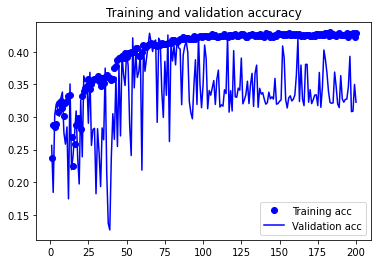

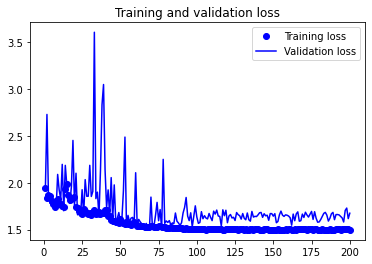

In [20]:
plot_history(history=train_history2)

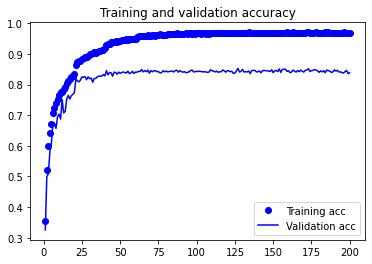

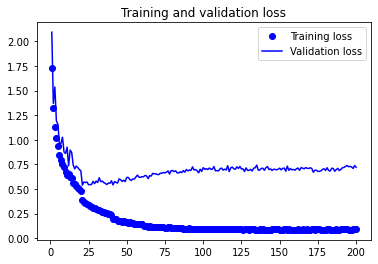

In [15]:
plot_history(history=train_history3)

In [21]:
def test(model, test_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

        print('Accuracy of the model on the test images: {} %'.format(100 * correct / len(test_loader.dataset)))

In [28]:
model_cnn_34 = Resnet(n_classes=10, batchnorm=True, residual=False).to(device)
model_cnn_34.load_state_dict(torch.load('model_cnn_34.pth'))

<All keys matched successfully>

In [29]:
test_loader = torch.utils.data.DataLoader(dataset=_test_dataset, batch_size=100, shuffle=False)
test(model_cnn_34, test_loader)

Accuracy of the model on the test images: 31.91 %


In [23]:
test_loader = torch.utils.data.DataLoader(dataset=_test_dataset, batch_size=100, shuffle=False)
test(model_res_34, test_loader)

Accuracy of the model on the test images: 84.49 %
